In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from multiprocessing import Pool, cpu_count
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import root_scalar

In [2]:
# Parameter lists
uM_neg_list = np.linspace(-8, -4, 3)
uM_pos_list = np.linspace(4, 8, 3)
aM_pos_list = np.linspace(0.2, 0.5, 4)
aM_neg_list = np.linspace(0.2, 0.5, 4)
k_neg_list  = np.linspace(3, 15, 3)
k_pos_list  = np.linspace(3, 15, 3)
param_combos = list(product(uM_neg_list, uM_pos_list,
                            aM_neg_list, aM_pos_list,
                             k_neg_list,  k_pos_list))

In [3]:
plt.rc('figure', dpi=133)
plt.rc('lines', linewidth=1)
plt.rc('font', size=10, family='sans-serif')
plt.rc('axes', titlesize=10, labelsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=10)

In [4]:
# Electrolyte model parameters
sM_neg, sM_pos = -80, 80
N = 201
tol, max_iter = 1e-8, 10000

In [5]:
# Range of surface charge densities
s_pos = np.linspace(0, 100, N)
s_neg = -s_pos

In [6]:
# Quantum parameters
a = 2    # Quantum capacitance minima at uq = 0 (PZC)
b = 21   # Slope of quantum capacitance dependence on uq
uq_neg = -np.sqrt((np.sqrt((2*s_neg)**2 + a**4) - a**2) / b**2)
uq_pos =  np.sqrt((np.sqrt((2*s_neg)**2 + a**4) - a**2) / b**2)
Cq_neg = ((a**2+b**2)*uq_neg**2 + a**2)/(2*np.sqrt(b**2*uq_neg**2 + a**2))
Cq_pos = ((a**2+b**2)*uq_neg**2 + a**2)/(2*np.sqrt(b**2*uq_pos**2 + a**2))
Cq_neg_inv = 1 / ((a**2+b**2)*uq_neg**2 + a**2)/(2*np.sqrt(b**2*uq_neg**2 + a**2))
Cq_pos_inv = 1 / ((a**2+b**2)*uq_neg**2 + a**2)/(2*np.sqrt(b**2*uq_pos**2 + a**2))

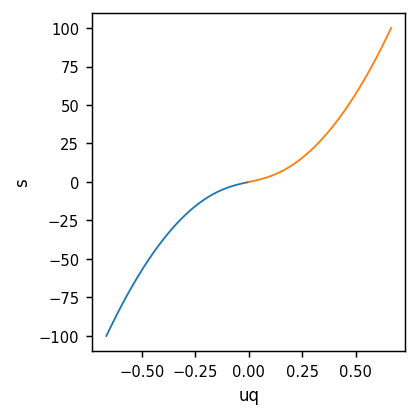

In [7]:
# Plot to check
plt.figure(figsize=(8.25/2.54, 8.25/2.54))
plt.plot(uq_neg, s_neg, label='s_neg vs uq_neg')
plt.plot(uq_pos, s_pos, label='s_pos vs uq_pos')
plt.xlabel('uq')
plt.ylabel('s')
plt.tight_layout()
plt.show()

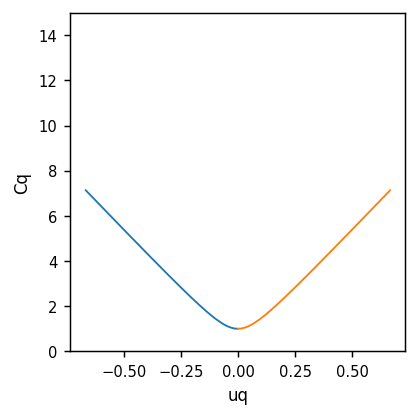

In [8]:
# Plot to check
plt.figure(figsize=(8.25/2.54, 8.25/2.54))
plt.plot(uq_neg, Cq_neg, label='Cq_neg vs uq_neg')
plt.plot(uq_pos, Cq_pos, label='Cq_pos vs uq_pos')
plt.xlabel('uq')
plt.ylabel('Cq')
plt.ylim(0, 15)
plt.tight_layout()
plt.show()

In [9]:
def solve_a(s, sM, aM, k):
    s = np.float64(s)
    sM = np.float64(sM)
    aM = np.float64(aM)
    k = np.float64(k)
    def f(a):
        if a <= 1e-6:
            return np.inf  # avoid division by tiny a
        try:
            exponent = (s / sM)**(1 / a)
            if np.isinf(exponent) or np.isnan(exponent):
                return np.inf
        except FloatingPointError:
            return np.inf
        return a - (aM + (1 - aM) * np.exp(-k * exponent))
    result = root_scalar(f, method='brentq', bracket=[1e-3, 10], xtol=1e-10)
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge")

In [10]:
def compute_branch(params):
    uM_neg, uM_pos, aM_neg,  aM_pos, k_neg, k_pos = params

    s_pos = np.linspace(0, 100, N)
    s_neg = -s_pos

    a_neg = np.array([solve_a(si, sM_neg, aM_neg, k_neg) for si in s_neg])
    a_pos = np.array([solve_a(si, sM_pos, aM_pos, k_pos) for si in s_pos])

    u_neg = uM_neg * (s_neg / sM_neg)**(1 / a_neg)
    u_pos = uM_pos * (s_pos / sM_pos)**(1 / a_pos)

    Ce_neg_inv = np.gradient(u_neg, s_neg) # inverse capacitance of electrolyte
    Ce_pos_inv = np.gradient(u_pos, s_pos) # inverse capacitance of electrolyte

    voltage = u_pos - u_neg # + uq_pos - uq_neg
    C_total = 1 / (Ce_neg_inv + Ce_pos_inv) # + Cq_neg_inv + Cq_pos_inv)

    s_tot = s_pos - s_neg
    ds = np.diff(s_tot)
    v_mid = 0.5 * (voltage[:-1] + voltage[1:])
    E_density = np.zeros_like(voltage)
    E_density[1:] = np.cumsum(v_mid * ds)

    idx_4V = np.argmin(np.abs(voltage - 4.0))
    E_at_4V = E_density[idx_4V]
    return voltage, C_total, E_density, s_tot, E_at_4V, params, s_neg, s_pos, u_neg, u_pos, a_neg, a_pos

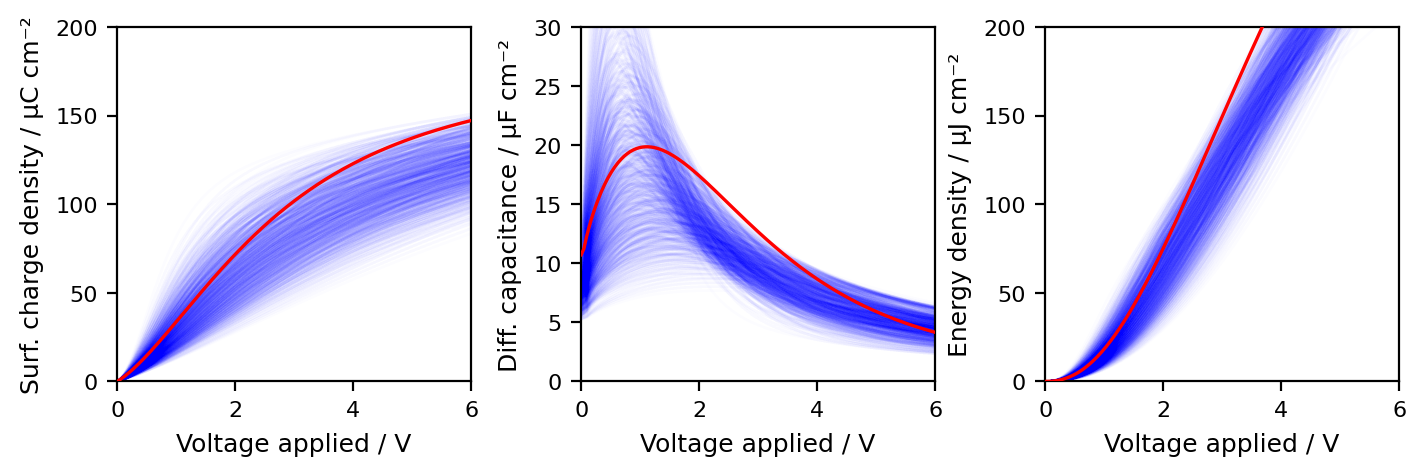

In [11]:
if __name__ == '__main__':
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_branch, param_combos)

    all_voltage, all_C_total, all_E_total, all_s_total, E_at_4V_list, all_params, s_neg, s_pos, u_neg, u_pos, a_neg, a_pos = zip(*results)
    best_idx = np.argmax(E_at_4V_list)
    best_params = all_params[best_idx]
    # 3-panel figure
    bw, gw = 1.77, 0.55
    fw, fh = 3*bw + 2*gw + 1.0, 3.0
    fig = plt.figure(figsize=(fw, fh), dpi=200)
    axs = []
    for i in range(3):
        left = (0.7 + i*(bw+gw))/fw
        bottom = ((fh-bw)/2)/fh
        width = bw/fw
        height = bw/fh
        ax = fig.add_axes([left, bottom, width, height])
        ax.set_aspect('auto')
        ax.tick_params(labelsize=8)
        axs.append(ax)
        ax.set_xlim(0,6); ax.grid(False)

    for volts, C, E, s in zip(all_voltage, all_C_total, all_E_total, all_s_total):
        axs[0].plot(volts, s, color='blue', alpha=0.01)
        axs[1].plot(volts, C, color='blue', alpha=0.01)
        axs[2].plot(volts, E, color='blue', alpha=0.01)

    axs[0].plot(all_voltage[best_idx], all_s_total[best_idx], color='red', lw=1.2, zorder=10)
    axs[1].plot(all_voltage[best_idx], all_C_total[best_idx], color='red', lw=1.2, zorder=10)
    axs[2].plot(all_voltage[best_idx], all_E_total[best_idx], color='red', lw=1.2, zorder=10)

    axs[0].set_xlabel('Voltage applied / V'); axs[0].set_ylim(0,200); axs[0].set_ylabel('Surf. charge density / μC cm⁻²')
    axs[1].set_xlabel('Voltage applied / V'); axs[1].set_ylim(0, 30); axs[1].set_ylabel('Diff. capacitance / μF cm⁻²')
    axs[2].set_xlabel('Voltage applied / V'); axs[2].set_ylim(0,200); axs[2].set_ylabel('Energy density / μJ cm⁻²')

    plt.savefig('predistions.png', dpi=600)
    plt.show()
    with open("bestcombination.txt", "w") as f:
        f.write(f"uM_neg={best_params[0]}, aM_neg={best_params[2]}, k_neg={best_params[4]}\n"
                f"uM_pos={best_params[1]}, aM_pos={best_params[3]}, k_pos={best_params[5]}\n")